## Supervised uMAP Study A

In [1]:
import warnings
warnings.filterwarnings("ignore")
#Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import spearmanr
from scipy.interpolate import make_interp_spline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import umap
#Configuration
WEAK_TIME_WEIGHT = 0.05
TARGET_WEIGHT    = 0.18
RANDOM_STATE     = 42
import random
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Read Data

In [2]:
wcct = pd.read_csv("WCCT_normalized_BL2.csv")
cons = pd.read_csv("Consolidated_A_B_minimal.csv")
populations = [p for p in cons["Consolidated Name"].unique() if p in wcct.columns]

### Filter shedders and valid days

In [3]:
wcct = wcct[(wcct["SHEDDER"] == 1) & (wcct["DPC"].isin([1,2,3,4,5,6,7]))].copy()
wcct = wcct.groupby(["VOLUNTEER","DPC"], as_index=False).mean()
good_ids = wcct.groupby("VOLUNTEER")["DPC"].nunique()
good_ids = good_ids[good_ids == 7].index
wcct = wcct[wcct["VOLUNTEER"].isin(good_ids)].copy()

### Detrend per volunteer

In [4]:
wcct[populations] = wcct.groupby("VOLUNTEER")[populations].transform(lambda x: x - x.mean())
X = wcct[populations].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_aug = np.column_stack([X_scaled, wcct["DPC"].values.reshape(-1,1) * WEAK_TIME_WEIGHT])

### Supervised uMAP

In [5]:
reducer = umap.UMAP(
    n_neighbors=100, min_dist=0.35, metric="correlation",
    target_metric="l2", target_weight=TARGET_WEIGHT,
    random_state=RANDOM_STATE,
    n_jobs=1
)
y_target = wcct["DPC"].values.reshape(-1,1)
embedding = reducer.fit_transform(X_aug, y=y_target)
wcct["uMAP1"] = (embedding[:,0] - embedding[:,0].min()) / (embedding[:,0].max() - embedding[:,0].min()) * 10
wcct["uMAP2"] = (embedding[:,1] - embedding[:,1].min()) / (embedding[:,1].max() - embedding[:,1].min()) * 10
r1, _ = spearmanr(wcct["DPC"], wcct["uMAP1"])
r2, _ = spearmanr(wcct["DPC"], wcct["uMAP2"])

### Train RF and predict

In [6]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf.fit(X_scaled, wcct["DPC"].values)
wcct["Predicted_DAY"] = np.clip(np.rint(rf.predict(X_scaled)), 1, 7).astype(int)

### Import color palettes

In [7]:
palette_df = pd.read_csv("viridis_tealrose_7bins.csv")
palette_df.columns = ["Day", "Actual_Color", "Predicted_Color"]

In [8]:
def color_map_from_csv(series, palette_column):
    color_dict = dict(zip(palette_df["Day"], palette_df[palette_column]))
    return [color_dict[int(d)] for d in series]

In [9]:
def clean_axes(ax):
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.2)
        spine.set_color("black")
    ax.set_xlabel("uMAP1", fontsize=12)
    ax.set_ylabel("uMAP2", fontsize=12)

In [10]:
def add_dot_legend(ax, title, palette_df, column):
    handles = [
        Line2D([0],[0], marker='o', linestyle='', 
               color=palette_df[column].iloc[i], 
               markersize=8, label=str(palette_df["Day"].iloc[i]))
        for i in range(len(palette_df))
    ]
    ax.legend(handles=handles, title=title,
              loc="upper left", bbox_to_anchor=(1.02,1), frameon=True)

### Plot uMAP and Trajectory

In [11]:
def plot_umap(df, hue_col, title, color_col):
    fig, ax = plt.subplots(figsize=(9,8))
    point_colors = color_map_from_csv(df[hue_col], color_col)
    ax.scatter(df["uMAP1"], df["uMAP2"], c=point_colors,
               s=85, edgecolors="none", zorder=1)

    from scipy.interpolate import splprep, splev
    cent = df.groupby("DPC")[["uMAP1","uMAP2"]].mean().sort_index()
    cent = cent.reset_index().sort_values("DPC")

    if len(cent) >= 4:
        # parametric smoothing spline to avoid overshoot
        tck, u = splprep([cent["uMAP1"], cent["uMAP2"]], s=0.5, k=3)
        u_fine = np.linspace(0, 1, 300)
        x_smooth, y_smooth = splev(u_fine, tck)
        ax.plot(x_smooth, y_smooth, color="#808080", lw=3, alpha=0.9, zorder=2)
    else:
        ax.plot(cent["uMAP1"], cent["uMAP2"],
                color="#808080", lw=3, alpha=0.9, zorder=2)
    for d, (x, y) in cent.set_index("DPC")[["uMAP1","uMAP2"]].iterrows():
        ax.text(
            x, y + 0.18, f"{int(d)}",
            ha="center", va="bottom",
            fontsize=13, weight="bold",
            color="black", zorder=3
    )
    ax.set_title(title, fontsize=14)
    clean_axes(ax)
    add_dot_legend(ax, "Day post challenge", palette_df, color_col)
    plt.tight_layout()
    plt.show()

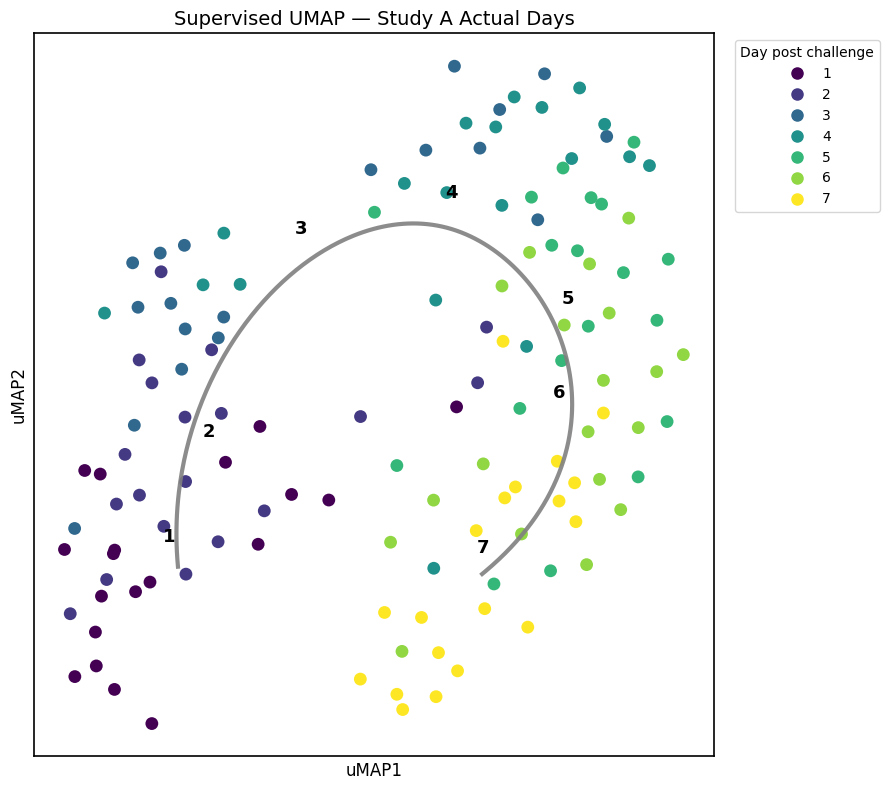

In [12]:
plot_umap(wcct, "DPC", "Supervised UMAP — Study A Actual Days", "Actual_Color")

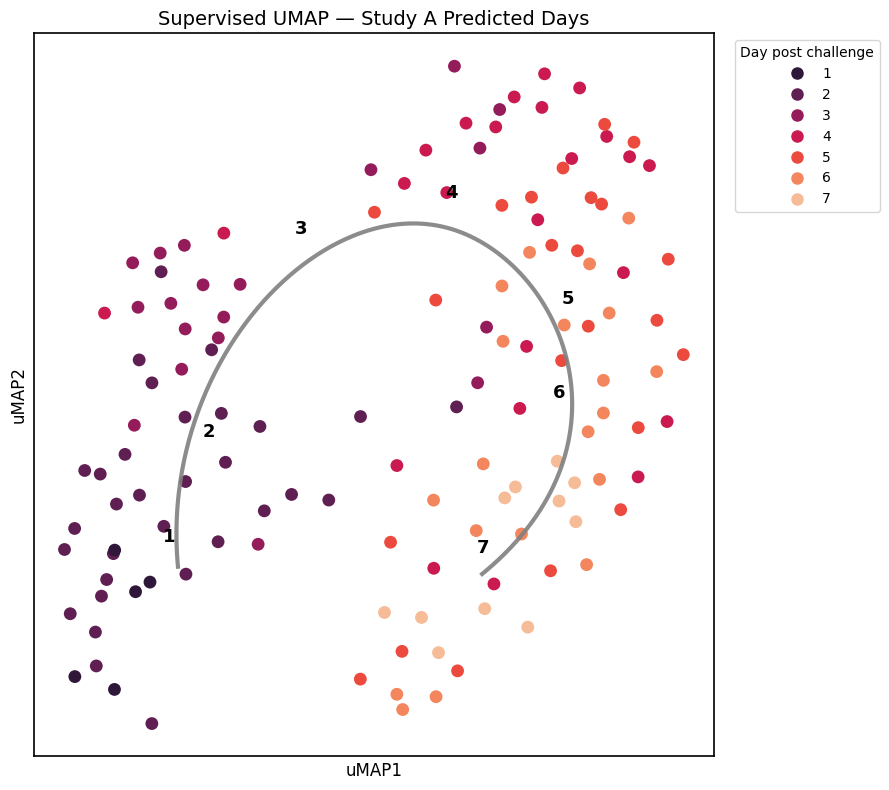

In [13]:
plot_umap(wcct, "Predicted_DAY", "Supervised UMAP — Study A Predicted Days", "Predicted_Color")